In [109]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

### Importing data

Here we're making a datetime index as out time series index and leaving out only monthly data for milk production.

In [38]:
#Importing and cleaning dataset
df = pd.read_csv('monthly-milk-production-pounds-p.csv',names = ['Month','Pounds per cow'])
df = df.drop([0])
df = df.dropna(axis=0, how='any')
#Let's convert index to datetime in order to perform time series later
df['Month'] = pd.to_datetime(df['Month'],errors='coerce')
df = df.set_index('Month')
#Let's resample time series to data reported at the end of the month
df = df.resample(rule='M').last()
df['Pounds per cow'] = pd.to_numeric(df['Pounds per cow'],downcast='float',errors='coerce')


### Checking stationarity of time series

#### Checking stationarity for time series of pounds per cow over the period of observations

Let's perform plotting of two time series, perform adfuller test and plot autocorrelation plot.

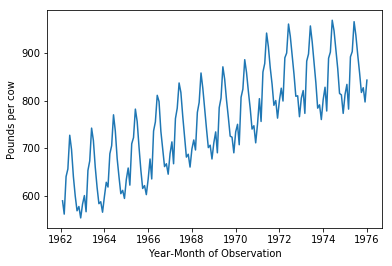

In [39]:
#Let's plot time series in order to check trend and seasonality components.
plt.plot(df.index,df['Pounds per cow'])
plt.xlabel('Year-Month of Observation')
plt.ylabel('Pounds per cow')
plt.show()

Conclusion: 
We see, that data has clearly trend and seasonality components.

The next check of stationarity will include plotting aucorrelation function.

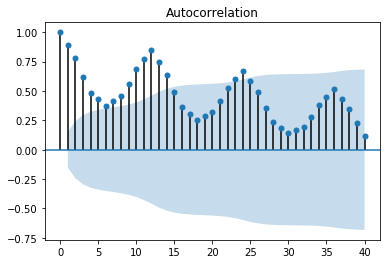

In [79]:
plot_acf(df['Pounds per cow'], lags=40, alpha=0.05)
plt.show()

Conclusion: The acf() demonstrates againg seasonality and trend of time series for amount of produced milk.

Let's plot a partial autocorrelation function

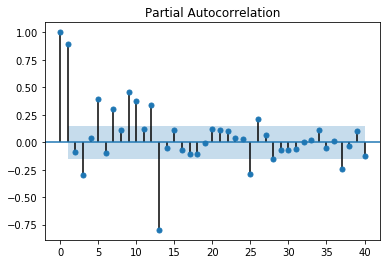

In [81]:
plot_pacf(df['Pounds per cow'], lags=40, alpha=0.05)
plt.show()

Conclusion:From the partial autocorrelation plot we know we need to add AR terms. 

We'll perform an augmented Dickey-Fuller test in order to see whether time series is stationary:
Let's remind ourselves that:
1) Null Hypothesis: *data is non-stationary*;
2) Alternative Hypothesis: *data is stationary* if *p-value* <= 0.5.

In [48]:
result = adfuller(df['Pounds per cow'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.303812
p-value: 0.627427
Critical Values:
	1%: -3.474
	5%: -2.880
	10%: -2.577


Conclusion: as p-value is 0.62 we accept out null hypothesis that time series is non-stationary, which means we need to difference the series and then produce our autocorrelation and partial acf plots. 

/home/alexus/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


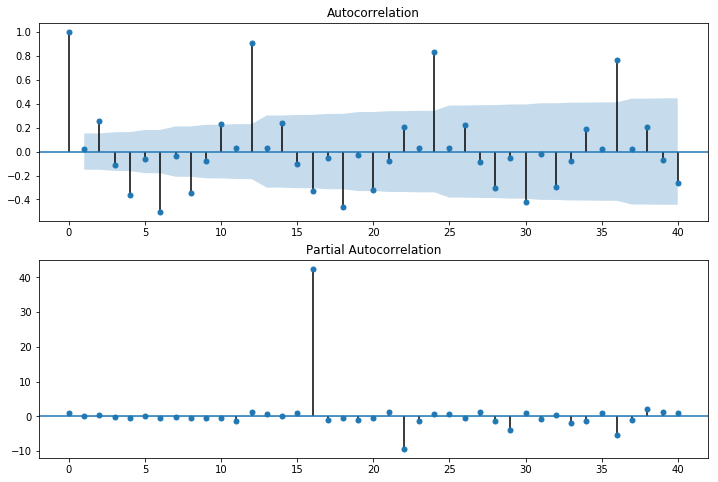

In [172]:
#performing first-order differencing
first_order_diff = df['Pounds per cow'].diff()
#deleting first NaN value, as it makes our plots impossible to plot.
first_order_diff = first_order_diff.drop(first_order_diff.index[0])
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(first_order_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(first_order_diff, lags=40, ax=ax2)
plt.show()

In [173]:
#Let's see whether we improved our p-value
result = adfuller(first_order_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.054996
p-value: 0.030068
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577


Conclusion: we improved our p-value under 5%.
From the autocorrelation plot we see that the optimal parameter MA for ARIMA model is going to be 2 - as this is observed periodicity.
PS. We didn't use other transformations apart from differencing for the sake of time economy for basic demonstration project, but adfuller test actually didn't guarantee that there is no seasonality in data.


Let's check Bayesian Information Criteria in order to determine what order of AR give the lowest information criteria - that's would be our testing value.

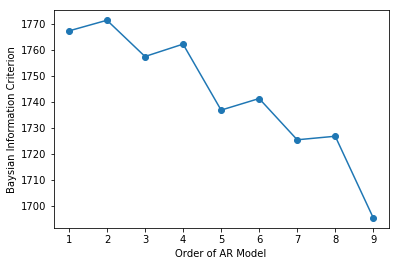

In [142]:
BIC = np.zeros(10)
for p in range(10):
    mod = ARMA(df['Pounds per cow'], order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,10), BIC[1:10], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Baysian Information Criterion')
plt.show()

Conclusion: the lowest BIC is going to be 9-10 (actualy 10, as bigger value is impossibe to put into ARIMA).

In [171]:
model = ARIMA(endog=df['Pounds per cow'],order=(10,1,2))
results=model.fit()
print(results.summary())

/home/alexus/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:       D.Pounds per cow   No. Observations:                  167
Model:                ARIMA(10, 1, 2)   Log Likelihood                -750.576
Method:                       css-mle   S.D. of innovations             20.473
Date:                Thu, 31 May 2018   AIC                           1529.152
Time:                        21:16:51   BIC                           1572.804
Sample:                    02-28-1962   HQIC                          1546.870
                         - 12-31-1975                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.5965        nan        nan        nan         nan         nan
ar.L1.D.Pounds per cow     -0.6788        nan        nan        nan         nan         nan


/home/alexus/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/alexus/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/alexus/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/alexus/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


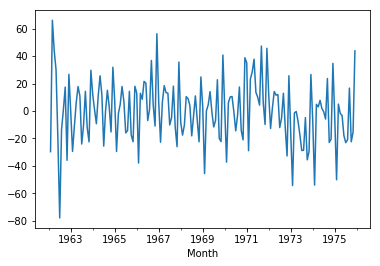

/home/alexus/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


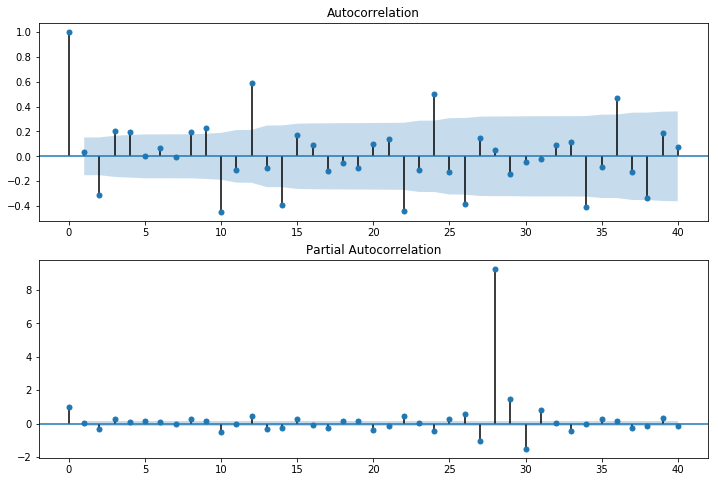

In [150]:
results.resid.plot()
plt.show()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(results.resid, lags=40, ax=ax2)
plt.show()

This is probably the best that we're able to do with a simple ARIMA model. So let’s use this model to forecast the next 12 months

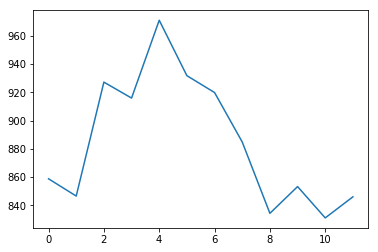

In [161]:
forecast,std,conf=results.forecast(12)
plt.plot(forecast)

Not bad result, but we also can make more long-term prediction with confidence intervals

/home/alexus/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


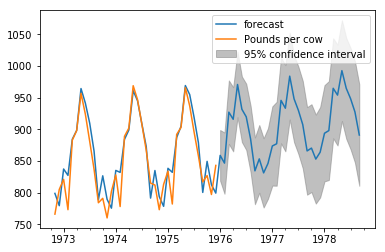

In [163]:
res = model.fit()
res.plot_predict(start=130, end=200)
plt.show()

This is our simple ARIMA forecast, where we used:
1) First-order differencing;
2) MA of order 2
3) AR of order 10